# NRL Team of the Year Analysis

The Dally M Team of the Year is the National Rugby League of Australia's equivalent to an all-Pro team in American sports.  Each week, journalists and commentators across Australia pick their team of the week and at the end of the season, the votes are combined to select a Team of the Year.  Since most of the people voting on team of the week are doing so subjectively, there is often a bit controversy when the Dally M Team of the Year is revealed at the end of the season.  Last year is a prime example:

https://www.sportingnews.com/au/league/news/dally-m-awards-fans-blow-up-over-dally-m-team-of-the-year-selections/1mds08rg0caso1afr28idjyzyo

While 6 of the 9 selections in 2018's Team of the Year were well received, there was plenty of outrage on social media over the selections of Joseph Leilua (centre), Luke Brooks (halfback) and Josh Jackson (second-row).  


In this analysis I will look into data from the 2018 NRL season to determine whether or not the Dally M Team of the Year was an accurate reflection of player performance.  The data I'm using was scraped from the official NRL website (www.nrl.com) using Selenium and Python's BeautifulSoup library and compiled into a database.  The database contains detailed player stats from every match.  In order to determine whether or not a player deserved to be in Team of the Year, I will first analyze various stats to determine which were the most highly correlated with a team's number of wins over the course of the season.  Once I've determined which stats are most important in contributing to a victory, I will compare players at each position by these stats to determine who deserved to be in 2018's Team of the Year.

In [1]:
#Deep analysis...try to see who came in 1st, 2nd, 3rd each week

In [2]:
#Import Pandas and connect to database
import pandas as pd
import mysql.connector as sql

mydb = sql.connect(
  host="localhost",
  user="root",
  passwd="NYg1@nts",
  database="NRL_data"
)

#Function to easily create dataframes from SQL query results
def create_df(query):
    return pd.read_sql_query(query, con=mydb)

# 2018 Final Team Standings

In order to determine which stats have the strongest correlation with total wins, I will put together an easy to read final standings list from the 2018 season.  The database contains entries for each individual match but does not aggregate wins or point differential for each team.

In [3]:
# Replace team_ids in Matches table with with team names from Teams table
match_query = '''SELECT m.id, m.round, m.date,
CASE
	WHEN m.home_team_id = m.winner THEN home.nickname
    ELSE away.nickname
END winner,
CASE
	WHEN m.home_team_id = m.winner THEN m.home_score
    ELSE m.away_score
END winning_score,
CASE
	WHEN m.home_team_id = m.winner THEN away.nickname
    ELSE home.nickname
END loser,
CASE
	WHEN m.home_team_id = m.winner THEN m.away_score
    ELSE m.home_score
END losing_score, home.nickname home, away.nickname away
FROM Matches m
JOIN Teams home
ON m.home_team_id = home.id
JOIN Teams away
ON m.away_team_id = away.id
WHERE year(m.date) = 2018
ORDER BY date;'''
matches_df = create_df(match_query).set_index('id')
matches_df.head()

,round,date,winner,winning_score,loser,losing_score,home,away
id,,,,,,,,
1,1,2018-03-08,Dragons,34,Broncos,12,Dragons,Broncos
2,1,2018-03-09,Knights,19,Sea Eagles,18,Knights,Sea Eagles
3,1,2018-03-09,Cowboys,20,Sharks,14,Cowboys,Sharks
6,1,2018-03-10,Storm,36,Bulldogs,18,Bulldogs,Storm
5,1,2018-03-10,Warriors,32,Rabbitohs,20,Rabbitohs,Warriors


In [4]:
#Create dataframe that combines points_scored and points_allowed in each team's victory
winners = matches_df.groupby('winner')
w_scored = winners['winning_score'].sum()
w_allowed = winners['losing_score'].sum()

#Create dataframe that combines points_scored and points_allowed in each team's loss
losers = matches_df.groupby('loser')
l_scored = losers['losing_score'].sum()
l_allowed = losers['winning_score'].sum()

#Combine dataframes
total_scores = pd.concat([w_scored, l_scored, w_allowed, l_allowed], axis=1, join='inner')
total_scores.columns = ['scored_in_win', 'scored_in_loss', 'allowed_in_win', 'allowed_in_loss']
total_scores.head(2)

#Calculate total points_differential, points_scored and points_allowed for each team
total_scores['pts_scored'] = total_scores['scored_in_win'] + total_scores['scored_in_loss']
total_scores['pts_allowed'] = total_scores['allowed_in_win'] + total_scores['allowed_in_loss']
total_scores['pts_differential'] = total_scores['pts_scored'] - total_scores['pts_allowed']
total_points_data = total_scores[['pts_differential', 'pts_scored', 'pts_allowed']]
total_points_data.head()

,pts_differential,pts_scored,pts_allowed
Broncos,56,556,500
Bulldogs,-46,428,474
Cowboys,-72,449,521
Dragons,47,519,472
Eels,-176,374,550


In [5]:
#Aggreate win / loss records for each team
win_loss_query = '''SELECT t.nickname team,
    count(m.winner) as wins,
    24 - count(m.winner) as loses
FROM Matches m
JOIN Teams t
ON m.winner = t.id
WHERE year(m.date) = 2018
GROUP BY m.winner
ORDER BY wins DESC;'''
win_loss_df = create_df(win_loss_query).set_index('team')
win_loss_df.head()

,wins,loses
team,,
Roosters,16,8
Rabbitohs,16,8
Storm,16,8
Sharks,16,8
Dragons,15,9


In [6]:
#Combine win/loss records with point differentials to create final standings
final_standings = pd.concat([win_loss_df, total_points_data], axis=1, join='inner').sort_values(['wins', 'pts_differential'], ascending=[0,0])
final_standings

,wins,loses,pts_differential,pts_scored,pts_allowed
Roosters,16,8,181,542,361
Storm,16,8,173,536,363
Rabbitohs,16,8,145,582,437
Sharks,16,8,96,519,423
Broncos,15,9,56,556,500
Panthers,15,9,56,517,461
Dragons,15,9,47,519,472
Warriors,15,9,25,472,447
Tigers,12,12,-83,377,460
Raiders,10,14,23,563,540


In [7]:
#Visualize if points_scored correlates highly with total wins
final_standings.plot.scatter(x='wins', y='pts_scored', color='Blue', label='scored')

We can see that there is a very weak correlation betwen points_scored and wins. Lets look at alternative metrics and player stats to find a better correlations with win totals.

# Finding correlations between win total and various team stats

The PlayerMatchStats table contains one entry for each player involved in every match. We will combine each player's individual contribution into one table that aggregates each statistical category by team for the 2018 season

In [8]:
#Replace player_ids and team_ids with names in the PlayerMatchStats table
query = '''SELECT CONCAT(p.first_name, ' ' ,p.last_name) name, t.nickname team, p_stats.*
        FROM PlayerMatchStats p_stats
        JOIN Players p
        ON p_stats.player_id = p.id
        JOIN Teams t
        ON p_stats.team_id = t.id
        JOIN Matches m
        ON p_stats.match_id = m.id
        WHERE year(m.date) = 2018;'''

player_stat_df = create_df(query)

player_stats_grouped = player_stat_df.groupby(['name', 'team']).agg(sum)
player_stats_grouped.head()

id  match_id  player_id  team_id  position_id  \
name         team                                                          
Aaron Gray   Sharks       275         9         87        4            3   
Aaron Woods  Bulldogs   26700       792       1428       42           84   
             Sharks     47691      1405        918       36           90   
Adam Blair   Warriors   69309      2047       4840      198          185   
Adam Doueihi Rabbitohs  51667      1527       6192      234          134   

                        minutes_played  points  tries  conversions  \
name         team                                                    
Aaron Gray   Sharks               80.0       0      0            0   
Aaron Woods  Bulldogs            785.0       0      0            0   
             Sharks              442.0       4      1            0   
Adam Blair   Warriors           1390.0       4      1            0   
Adam Doueihi Rabbitohs           674.0      26      2            8   

                        conversion_attempts  ...  fourty_twenty  \
name         team                            ...                  
Aaron Gray   Sharks                       0  ...              0   
Aaron Woods  Bulldogs                     0  ...              0   
             Sharks                       0  ...              0   
Adam Blair   Warriors                     0  ...              0   
Adam Doueihi Rabbitohs                   14  ...              0   

                        cross_field_kicks  kicked_dead  errors  \
name         team                                                
Aaron Gray   Sharks                     0            0       2   
Aaron Woods  Bulldogs                   0            0      10   
             Sharks                     0            0       4   
Adam Blair   Warriors                   0            0      12   
Adam Doueihi Rabbitohs                  0            2       4   

                        handling_errors  one_on_ones_lost  penalties  \
name         team                                                      
Aaron Gray   Sharks                   0                 0          1   
Aaron Woods  Bulldogs                 8                 0         18   
             Sharks                   3                 0          9   
Adam Blair   Warriors                 8                 0         11   
Adam Doueihi Rabbitohs                2                 0          6   

                        on_report  sin_bins  send_offs  
name         team                                       
Aaron Gray   Sharks             0         0          0  
Aaron Woods  Bulldogs           0         0          0  
             Sharks             0         1          0  
Adam Blair   Warriors           0         1          0  
Adam Doueihi Rabbitohs          0         0          0  

[5 rows x 51 columns]

We can see that there are 57 columns in the player stat dataframe. We want to slim this number down to make our analysis a little more manageable.

In [9]:
player_stat_df.columns

Index(['name', 'team', 'id', 'match_id', 'player_id', 'team_id', 'position_id',
       'minutes_played', 'points', 'tries', 'conversions',
       'conversion_attempts', 'penalty_goals', 'conversion_percentage',
       'field_goals', 'total_runs', 'total_run_metres', 'kick_return_metres',
       'post_contact_metres', 'line_breaks', 'line_break_assists',
       'try_assists', 'line_engaged_runs', 'tackle_breaks', 'hit_ups',
       'play_the_ball', 'average_play_ball_seconds', 'dummy_half_runs',
       'dummy_half_run_metres', 'steals', 'offloads', 'dummy_passes', 'passes',
       'receipts', 'pass_to_run_ratio', 'tackle_percentage', 'tackles_made',
       'tackles_missed', 'ineffective_tackles', 'intercepts', 'kicks_defused',
       'kicks', 'kicking_metres', 'forced_drop_outs', 'bomb_kicks', 'grubbers',
       'fourty_twenty', 'cross_field_kicks', 'kicked_dead', 'errors',
       'handling_errors', 'one_on_ones_lost', 'penalties', 'on_report',
       'sin_bins', 'send_offs', 'stint_one'

We can see from the list of columns that almost all of the stats fall into several categories: scoring, running, kicking, defensive/tackling, and errors/penalties. To simplify the anlaysis, we will only include the more encompassing stats for each category. Using running stats as an example, we will include total_run_metres but ignore more refined stats like kick_return_metres and post_contact_metres which both are included in total_run_metres.  I will also create columns for stats like metres_per_kick and tackle_percentage which aren't included in the initial PlayerMatchStat table but can easily be calculated.

In [10]:
team_stats = player_stat_df.groupby('team').agg(sum)

#Combine aggregated stats with teams' win total
slimmed_team_stats = team_stats[['points', 'tries', 'try_assists', 'total_runs', 'total_run_metres', 'tackles_made', 'tackles_missed', 'ineffective_tackles',
           'kicks', 'kicking_metres', 'errors', 'penalties']]
wins = final_standings[['wins', 'pts_differential', 'pts_scored', 'pts_allowed']]
team_stats = pd.concat([wins, slimmed_team_stats], axis=1, join='inner').sort_values(['wins', 'pts_differential'], ascending=[0,0])

#Add columns for categories that calculate averages
team_stats['metres_per_kick'] = team_stats['kicking_metres'] / team_stats['kicks']
team_stats['metres_per_run'] = team_stats['total_run_metres'] / team_stats['total_runs']
team_stats['tackle_percentage'] = team_stats['tackles_made'] / (team_stats[['tackles_made', 'tackles_missed', 'ineffective_tackles']].sum(axis = 1))

team_stats

,wins,pts_differential,pts_scored,pts_allowed,points,tries,try_assists,total_runs,total_run_metres,tackles_made,tackles_missed,ineffective_tackles,kicks,kicking_metres,errors,penalties,metres_per_kick,metres_per_run,tackle_percentage
Roosters,16,181,542,361,542,88,75,3985,38078,7925,653,457,443,11304,276,198,25.516930,9.555332,0.877144
Storm,16,173,536,363,552,89,60,3963,35278,7731,661,372,427,10477,255,196,24.536300,8.901842,0.882131
Rabbitohs,16,145,582,437,582,98,75,4174,38270,7582,710,348,398,10403,242,202,26.138191,9.168663,0.877546
Sharks,16,96,519,423,519,87,73,4168,36898,7381,711,393,414,10554,245,201,25.492754,8.852687,0.869888
Broncos,15,56,556,500,556,88,58,3920,35810,7749,784,350,459,13071,207,189,28.477124,9.135204,0.872340
Panthers,15,56,517,461,517,82,61,4107,36797,7624,906,305,414,10226,237,226,24.700483,8.959581,0.862932
Dragons,15,47,519,472,519,82,56,4178,37300,7846,638,430,445,11611,246,169,26.092135,8.927717,0.880188
Warriors,15,25,472,447,472,80,63,4036,36947,7855,844,300,416,11186,219,206,26.889423,9.154361,0.872875
Tigers,12,-83,377,460,377,61,41,3999,34998,8583,957,373,468,11911,233,197,25.450855,8.751688,0.865833
Raiders,10,23,563,540,563,93,66,3745,34450,7315,804,354,373,9442,233,225,25.313673,9.198932,0.863331


In [11]:
#Visualize correlations between different statistical categories
corr = team_stats.corr()
corr.style.background_gradient(cmap='coolwarm')

,wins,pts_differential,pts_scored,pts_allowed,points,tries,try_assists,total_runs,total_run_metres,tackles_made,tackles_missed,ineffective_tackles,kicks,kicking_metres,errors,penalties,metres_per_kick,metres_per_run,tackle_percentage
wins,1,0.880937,0.638568,-0.810735,0.63945,0.606989,0.472729,0.302693,0.526924,-0.129917,-0.0989203,0.0441723,0.0918198,0.370492,0.090965,0.015031,0.495521,0.367506,0.0257391
pts_differential,0.880937,1,0.794954,-0.861693,0.801643,0.735517,0.63809,0.222287,0.621915,-0.366399,-0.333475,0.206957,-0.025476,0.119239,0.293341,0.0296407,0.221232,0.590228,0.0668156
pts_scored,0.638568,0.794954,1,-0.377163,0.997865,0.961526,0.759854,-0.0684722,0.420186,-0.708783,-0.327131,0.0529774,-0.452299,-0.163936,0.190371,0.260213,0.216988,0.647132,-0.133215
pts_allowed,-0.810735,-0.861693,-0.377163,1,-0.38916,-0.318606,-0.338557,-0.396617,-0.597968,-0.0334912,0.235467,-0.271631,-0.339419,-0.31915,-0.288587,0.172397,-0.156241,-0.359773,-0.213425
points,0.63945,0.801643,0.997865,-0.38916,1,0.963253,0.748322,-0.0816481,0.397294,-0.704274,-0.333186,0.0512675,-0.452413,-0.174189,0.213583,0.263841,0.200654,0.630738,-0.119709
tries,0.606989,0.735517,0.961526,-0.318606,0.963253,1,0.812627,-0.151915,0.309464,-0.655661,-0.290647,-0.0273131,-0.551286,-0.212704,0.221366,0.369534,0.252817,0.588978,-0.100677
try_assists,0.472729,0.63809,0.759854,-0.338557,0.748322,0.812627,1,0.0872325,0.485877,-0.677807,-0.407576,0.096186,-0.538081,-0.351675,0.395566,0.256467,0.0329128,0.558111,-0.0297182
total_runs,0.302693,0.222287,-0.0684722,-0.396617,-0.0816481,-0.151915,0.0872325,1,0.689896,0.00263469,-0.326704,0.178431,0.302768,0.184715,0.0107553,-0.537061,-0.015012,-0.198148,0.367424
total_run_metres,0.526924,0.621915,0.420186,-0.597968,0.397294,0.309464,0.485877,0.689896,1,-0.252905,-0.425283,0.315251,0.107769,0.109423,0.172065,-0.236165,0.0608032,0.572726,0.218716
tackles_made,-0.129917,-0.366399,-0.708783,-0.0334912,-0.704274,-0.655661,-0.677807,0.00263469,-0.252905,1,0.328969,0.0807315,0.702889,0.627124,-0.124332,-0.248572,0.248174,-0.352383,0.285623


We can see from this chart how various stats in our analysis correlate with a team's win total. There are some fairly obvious stats with strong correlations like points_scored, total_run_metres and tries (the rugby equivalent of a touchdown in football). There are also some stats with correlations that are a bit surprising.  I would have predicted to see a strong negative correlation between wins and errors, however, the correlation is slightly positive although very weak.  This could be explained by the fact that many errors fall under the category of "handling errors" which means that a team with posession dropped the ball, thereby surrending it to the other team.  Teams with more position are more likely to commit handling errors and similarly, teams with more posession are likely to score more points which correlates highly with winning.

# Identifying top performers at each position

I will now compare players at each position based off of the stats that have the biggest impact on a team's win total. When conducting deeper analysis on the controversial selections, I will also take into conserdation the stats that are more applicable to the individual positions.  Player positions in rugby can be fall under the categories of forwards or backs. Forwards tend to be larger, slower players who have more of a defenisve impact while spending most of their time towards the middle of the field.  Backs tend to play out wide because they're smaller and quicker which makes them more of an attacking threat in space.  Backs also tend to do the vast majority of a team's kicking. 

For the purposes of this analyis, each player will be assigned to the position at which they played the most matches over the course of the 2018 season

In [12]:
#Find position at which each player played the most games
from scipy.stats import mode

position_df = player_stat_df[['name', 'position_id']]
modes = position_df.groupby('name')['position_id'].apply(lambda x: mode(x)[0][0]).reset_index().rename(columns={"position_id": "main_position"})

#Combine player positions with dataframe of aggregate statistics
player_stats_final = pd.merge(modes, player_stats_grouped, how='left', on='name')

#Create columns for additional statistics
player_stats_final = player_stats_final.drop(columns=['match_id', 'position_id'])
player_stats_final['metres_per_run'] = player_stats_final['total_run_metres'] / player_stats_final['total_runs']
player_stats_final['metres_per_kick'] = player_stats_final['kicking_metres'] / player_stats_final['kicks']
player_stats_final['tackle_percentage'] = player_stats_final['tackles_made'] / (player_stats_final['tackles_made'] + player_stats_final['tackles_missed'] + player_stats_final['ineffective_tackles'])

#Clean up dataframe
player_stats_final = player_stats_final.drop(columns=['id', 'player_id', 'team_id'])
stat_columns = player_stats_final.columns[2:]
player_stats_final = player_stats_final.groupby(['name', 'main_position'])[stat_columns].agg('sum')
player_stats_final = player_stats_final.reset_index()
player_stats_final.head()

,name,main_position,minutes_played,points,tries,conversions,conversion_attempts,penalty_goals,field_goals,total_runs,...,errors,handling_errors,one_on_ones_lost,penalties,on_report,sin_bins,send_offs,metres_per_run,metres_per_kick,tackle_percentage
0,Aaron Gray,3,80.0,0,0,0,0,0,0,8,...,2,0,0,1,0,0,0,6.625000,0.000000,0.827586
1,Aaron Woods,6,1227.0,4,1,0,0,0,0,363,...,14,11,0,27,0,1,0,17.704908,0.000000,1.865554
2,Adam Blair,9,1390.0,4,1,0,0,0,0,169,...,12,8,0,11,0,1,0,7.668639,0.000000,0.889488
3,Adam Doueihi,10,674.0,26,2,8,14,1,0,87,...,4,2,0,6,0,0,0,8.735632,27.305556,0.860294
4,Adam Elliott,9,1063.0,16,4,0,0,0,0,240,...,6,3,0,15,0,0,0,7.733333,0.000000,0.883333


Now that we have a finalized dataframe displaying all players, their main position, and their stats from the course of the 2018 season, we can analyze who stood out at each position.  We will remove all players who played less than 800 minutes (the equivalent of 10 full matches) from this analysis.

In [13]:
#Remove everyone who played less than the equivalent of 10 full matches 
player_stats_final = player_stats_final[player_stats_final['minutes_played'] > 800]

#Create dictionary of player stats for each position
main_stats = ['name', 'main_position', 'minutes_played', 'tries', 'try_assists', 'total_run_metres', 'total_runs', 'metres_per_run', 'kicks', 'kicking_metres', 'metres_per_kick', 'tackles_made', 'tackle_percentage']
positions = ['Fullback', 'Wing', 'Centre', 'Five-Eigth', 'Halfback', 'Prop', 'Hooker', '2nd Row', 'Lock']
positions_dict = {}
for i in range(10):
    if i > 0:
        important_stats = player_stats_final[main_stats]
        position = important_stats[important_stats['main_position'] == i]
        positions_dict[i] = position.sort_values(['total_run_metres', 'tries'], ascending = [0,0])
        
#Convert dictionary into a dataframe and only include top performers at each position 
stat_leader_df = pd.DataFrame()      
for key in positions_dict:
    stat_leader_df = pd.concat([stat_leader_df, positions_dict[key][:7]])

stat_leader_df['main_position'] = stat_leader_df['main_position'].apply(lambda x: positions[x - 1])
stat_leader_df.set_index('name')

,main_position,minutes_played,tries,try_assists,total_run_metres,total_runs,metres_per_run,kicks,kicking_metres,metres_per_kick,tackles_made,tackle_percentage
name,,,,,,,,,,,,
James Tedesco,Fullback,1748.0,9,11,4202,377,11.145889,6,86,14.333333,114,0.802817
Roger Tuivasa-sheck,Fullback,1743.0,3,8,4045,391,10.345269,2,22,11.000000,66,0.600000
Tom Trbojevic,Fullback,1712.0,9,14,3842,386,9.953368,26,376,14.461538,96,0.705882
Valentine Holmes,Fullback,1841.0,21,8,3400,318,10.691824,11,121,11.000000,83,0.664000
Matthew Dufty,Fullback,1893.0,12,8,3071,297,10.340067,4,69,17.250000,102,0.713287
Kalyn Ponga,Fullback,1529.0,6,11,2842,311,9.138264,53,1288,24.301887,105,0.677419
Moses Mbye,Fullback,1760.0,6,5,2785,316,17.454219,72,2273,46.367647,121,1.386438
Blake Ferguson,Wing,1918.0,17,4,4880,486,10.041152,5,73,14.600000,81,0.764151
George Jennings,Wing,2746.0,15,0,4192,469,17.966937,1,19,19.000000,243,1.641860


In the above analysis, I chose to sort players first by total_run_metres and then by tries.  Even though tries have a stronger correlation with wins than total running metres, many tries involve the contributions of many different players similar to touchdowns in football.  In order to determine which individual players excelled in comparison to others, I felt that running meters would be a good starting point since this is one of the strongest indicators of a player's overall performance regardless of their position or stle of play.

# Comparing the 2018 Team of the Year to stat leaders

#First...We'll look at Centres and Second Rowers to see why Leilua and Jackson are in the team despite not being top in their positions

#Second...We'll do the same type of analysis for Second Rowers

#Third...We'll look into Tedesco vs. Tuivasa-Sheck

## Centres

In [15]:
#Do a deep analysis into running stats
centre_df = player_stats_final[player_stats_final['main_position'] == 3]
centre_df = centre_df[main_stats]
centre_df = centre_df.sort_values(['total_run_metres', 'tries', 'metres_per_kick', 'total_runs', 'tackle_percentage'], ascending = [0,0,0,0, 0]).set_index('name')
centre_df.head(7)

,main_position,minutes_played,tries,try_assists,total_run_metres,total_runs,metres_per_run,kicks,kicking_metres,metres_per_kick,tackles_made,tackle_percentage
name,,,,,,,,,,,,
Will Hopoate,3,1920.0,5,7,3854,431,8.941995,6,86,14.333333,247,0.801948
Esan Marsters,3,1928.0,3,7,3103,336,9.235119,9,102,11.333333,322,0.827763
Euan Aitken,3,1765.0,10,1,2628,294,8.938776,1,3,3.000000,360,0.841121
Ricky Leutele,3,1727.0,3,5,2598,280,9.278571,14,287,20.500000,234,0.844765
Dane Gagai,3,1759.0,3,10,2546,281,9.060498,7,117,16.714286,344,0.785388
Timoteo Lafai,3,1920.0,5,4,2495,280,8.910714,2,31,15.500000,275,0.828313
Joseph Leilua,3,1741.0,14,3,2481,262,9.469466,5,60,12.000000,215,0.776173


Surprisingly, Joseph Leilua doesn't even make the top 5 for total running meters in a position where running stats are of the highest importance. Leilua, however, scored a lot more tries than the other players who had more running meters.  We'll now narrow our analysis to the top-3 rushing leaders plus Leilua and Latrell Mitchell, who was viewed as one of the biggest snubs from the Team of the Year.

In [23]:
centre_list = ['Will Hopoate', 'Esan Marsters', 'Euan Aitken', 'Joseph Leilua', 'Latrell Mitchell']
top_centres = centre_df.loc[centre_list]
top_centres

,main_position,minutes_played,tries,try_assists,total_run_metres,total_runs,metres_per_run,kicks,kicking_metres,metres_per_kick,tackles_made,tackle_percentage
name,,,,,,,,,,,,
Will Hopoate,3,1920.0,5,7,3854,431,8.941995,6,86,14.333333,247,0.801948
Esan Marsters,3,1928.0,3,7,3103,336,9.235119,9,102,11.333333,322,0.827763
Euan Aitken,3,1765.0,10,1,2628,294,8.938776,1,3,3.000000,360,0.841121
Joseph Leilua,3,1741.0,14,3,2481,262,9.469466,5,60,12.000000,215,0.776173
Latrell Mitchell,3,1705.0,15,6,1738,169,10.284024,6,66,11.000000,194,0.811715


In [71]:
#matches_df = create_df(match_query)
rounds = matches_df['round']
#rounds.head()
stats_by_round = player_stat_df.join(rounds, on='match_id', lsuffix='_player', rsuffix='_match').set_index('name')
c_stats = stats_by_round[stats_by_round['position_id'] == 3]
c_stats.columns
c_stats = c_stats[['round','tries', 'total_run_metres', 'try_assists', 'steals', 'tackle_percentage', 'intercepts', 'kicking_metres', 'penalties', 'errors']]

top_performers_by_round = {}
for i in range(1, 26):
    #top_performers_by_round[i] = 
    round_df = c_stats[c_stats['round'] == i]
    round_df['rating'] = ((round_df['tries'] * 5) + (round_df['total_run_metres'] / 10) + 
        (round_df['try_assists'] * 2.5) + round_df['steals'] + (round_df['tackle_percentage'].astype(float) * 5) +
        round_df['intercepts'] + (round_df['kicking_metres'] / 25) - (round_df['penalties'] * 2) -
        round_df['errors'])
    round_df = round_df.sort_values('rating', ascending=0).head(3).reset_index()
    round_df['round_score'] = [3, 2, 1]
    top_performers_by_round[i] = round_df[['name', 'round_score']]

top_performers_by_round

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

{1:             name  round_score
 0     Waqa Blake            3
 1  Ricky Leutele            2
 2    Euan Aitken            1, 2:                name  round_score
 0         Peta Hiku            3
 1  Latrell Mitchell            2
 2       Euan Aitken            1, 3:             name  round_score
 0  Timoteo Lafai            3
 1    Josh Morris            2
 2   Will Hopoate            1, 4:             name  round_score
 0    Josh Morris            3
 1  Solomone Kata            2
 2  Esan Marsters            1, 5:             name  round_score
 0  Joseph Leilua            3
 1      Peta Hiku            2
 2    Euan Aitken            1, 6:             name  round_score
 0  Ricky Leutele            3
 1    Ben Hampton            2
 2    Euan Aitken            1, 7:             name  round_score
 0    Ben Hampton            3
 1    Greg Inglis            2
 2  Will Chambers            1, 8:               name  round_score
 0     Will Hopoate            3
 1  Anthony Gelling           

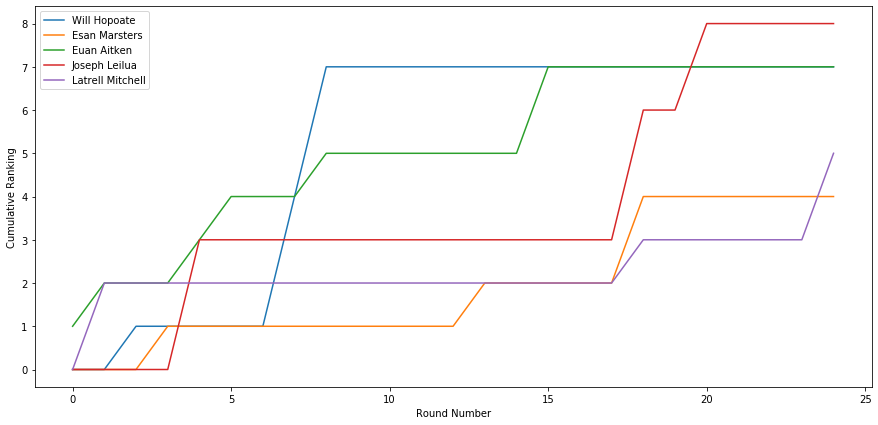

In [72]:
import matplotlib.pyplot as plt

weekly_tally = dict.fromkeys(centre_list)

#weekly_tally --> player --> i

for player in centre_list:
    weekly_tally[player] = {}
    for i in range(1, 26):
        weekly_score_df = top_performers_by_round[i].set_index('name')
        if i == 1:
            if player in list(weekly_score_df.index.values):
                #score = weekly_score_df[player]['round_score']
                weekly_tally[player][i] = weekly_score_df.loc[player]['round_score']
            else:
                weekly_tally[player][i] = 0
        else:
            if player in weekly_score_df.index.values:
                weekly_tally[player][i] = weekly_tally[player][i - 1] + weekly_score_df.loc[player]['round_score']
            else:
                weekly_tally[player][i] = weekly_tally[player][i - 1]

#list(range(len(weekly_tally['Euan Aitken']) + 1))
#list(weekly_tally['Euan Aitken'].values())
fig = plt.figure(figsize=(15, 7))
for player in list(weekly_tally.keys()):
    x = list(range(len(weekly_tally[player])))
    y = list(weekly_tally[player].values())
    plt.plot(x, y, label=player)
plt.legend(loc='upper left')
plt.xlabel("Round Number")
plt.ylabel("Cumulative Ranking")
plt.show()


## Second Row

In [80]:
sr_df = player_stats_final[player_stats_final['main_position'] == 8]
sr_df = sr_df[sr_df['minutes_played'] > 800]
sr_df = sr_df.sort_values(['total_run_metres', 'tries', 'metres_per_kick', 'total_runs', 'tackle_percentage'], ascending = [0,0,0,0,0])
sr_df = sr_df.set_index('name').head(13)
sr_df
#sr_df.drop(columns=['id', 'player_id', 'team_id', 'main_position'])

,main_position,minutes_played,points,tries,conversions,conversion_attempts,penalty_goals,field_goals,total_runs,total_run_metres,...,errors,handling_errors,one_on_ones_lost,penalties,on_report,sin_bins,send_offs,metres_per_run,metres_per_kick,tackle_percentage
name,,,,,,,,,,,,,,,,,,,,,
Viliame Kikau,8,1593.0,20,5,0,0,0,0,313,2931,...,19,16,0,11,0,1,0,9.364217,13.600000,0.819967
Angus Crichton,8,1744.0,12,3,0,0,0,0,340,2864,...,25,23,0,26,0,0,0,8.423529,21.000000,0.902527
John Sutton,8,1842.0,16,4,0,0,0,0,301,2755,...,8,7,1,10,0,0,0,9.152824,8.714286,0.904690
Isaah Yeo,8,1757.0,12,3,0,0,0,0,283,2694,...,11,10,0,13,0,0,0,9.519435,16.750000,0.924936
Tariq Sims,8,1770.0,28,7,0,0,0,0,275,2462,...,10,8,0,16,0,0,0,8.952727,27.000000,0.874636
Boyd Cordner,8,1534.0,12,3,0,0,0,0,264,2453,...,13,9,0,12,0,0,0,9.291667,26.000000,0.866667
Aidan Guerra,8,1674.0,20,5,0,0,0,0,295,2365,...,6,4,0,15,0,1,0,8.016949,16.000000,0.895775
Tevita Pangai Junior,8,1052.0,20,5,0,0,0,0,254,2348,...,13,10,1,13,1,1,0,9.244094,14.000000,0.888031
Shaun Lane,8,1295.0,36,9,0,0,0,0,234,2291,...,14,10,0,10,0,0,0,9.790598,0.000000,0.902758


In [76]:
rounds = matches_df['round']
stats_by_round = player_stat_df.join(rounds, on='match_id', lsuffix='_player', rsuffix='_match').set_index('name')
sr_stats = stats_by_round[stats_by_round['position_id'] == 8]
sr_stats = sr_stats[['round','tries', 'total_run_metres', 'try_assists', 'steals', 'tackle_percentage', 'intercepts', 'kicking_metres', 'penalties', 'errors']]

top_performers_by_round = {}
for i in range(1, 26):
    round_df = sr_stats[sr_stats['round'] == i]
    round_df['rating'] = ((round_df['tries'] * 5) + (round_df['total_run_metres'] / 10) + 
        (round_df['try_assists'] * 2.5) + round_df['steals'] + (round_df['tackle_percentage'].astype(float) * 5) +
        round_df['intercepts'] + (round_df['kicking_metres'] / 25) - (round_df['penalties'] * 2) -
        round_df['errors'])
    round_df = round_df.sort_values('rating', ascending=0).head(3).reset_index()
    round_df['round_score'] = [3, 2, 1]
    top_performers_by_round[i] = round_df[['name', 'round_score']]

#top_performers_by_round

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

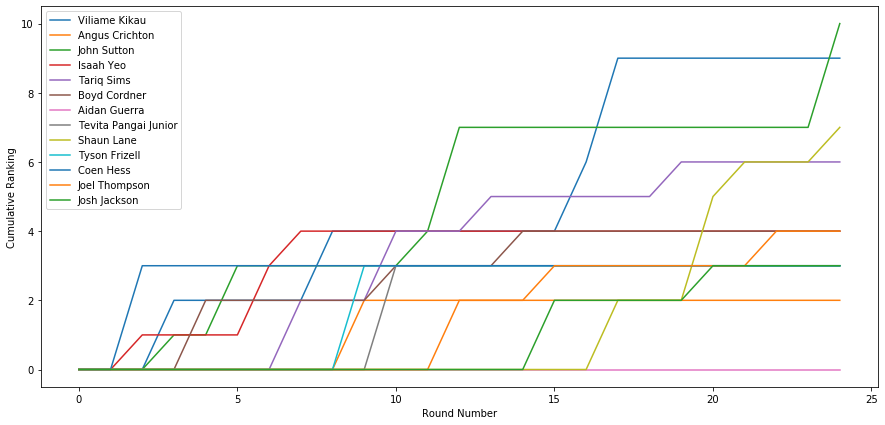

In [83]:
weekly_tally = dict.fromkeys(sr_df.index.values)

#weekly_tally --> player --> i

for player in list(sr_df.index.values):
    weekly_tally[player] = {}
    for i in range(1, 26):
        weekly_score_df = top_performers_by_round[i].set_index('name')
        if i == 1:
            if player in list(weekly_score_df.index.values):
                #score = weekly_score_df[player]['round_score']
                weekly_tally[player][i] = weekly_score_df.loc[player]['round_score']
            else:
                weekly_tally[player][i] = 0
        else:
            if player in weekly_score_df.index.values:
                weekly_tally[player][i] = weekly_tally[player][i - 1] + weekly_score_df.loc[player]['round_score']
            else:
                weekly_tally[player][i] = weekly_tally[player][i - 1]

fig = plt.figure(figsize=(15, 7))
for player in list(weekly_tally.keys()):
    x = list(range(len(weekly_tally[player])))
    y = list(weekly_tally[player].values())
    plt.plot(x, y, label=player)
plt.legend(loc='upper left')
plt.xlabel("Round Number")
plt.ylabel("Cumulative Ranking")
plt.show()

# Rank players based on how big an impact they had for their respective teams

The below formuala takes in a dictionary of players and their respective teams and returns a dataframe comparing a players' impacts on their teams overall statistical output

In [31]:
def compare_individual_contribution_to_team(player_dict):
    def find_team_stats(team_name, stat):
        stats = team_stats.loc[team_name]
        return stats[stat]
    
    individual_impact = {}

    for name, team in player_dict.items():
        individual_impact[name] = {}
        individual_impact[name]['name'] = name
        player_df = stat_leader_df[stat_leader_df['name'] == name]
        player_df = player_df[['name', 'tries', 'try_assists', 'total_run_metres', 'total_runs', 'kicks', 'kicking_metres', 'tackles_made']]
        i = 0
        while i < len(player_df.columns):
            try:
                combined_team_stat = find_team_stats(team, player_df.columns[i])
                percent_of_team_stat = player_df[player_df.columns[i]] / combined_team_stat
                individual_impact[name][player_df.columns[i]] = (percent_of_team_stat.item() * 100)
                i += 1
            except:
                i += 1
                continue

    comparison_dataframe = pd.DataFrame()
    for i in individual_impact:
        player_dataframe = pd.DataFrame([individual_impact[i]], columns=individual_impact[i].keys())
        comparison_dataframe = pd.concat([comparison_dataframe, player_dataframe])
    return comparison_dataframe.set_index('name').round(2)

# Fullbacks

In [33]:
stat_leader_df.set_index('name').loc[['James Tedesco', 'Roger Tuivasa-sheck']]

,main_position,minutes_played,tries,try_assists,total_run_metres,total_runs,metres_per_run,kicks,kicking_metres,metres_per_kick,tackles_made,tackle_percentage
name,,,,,,,,,,,,
James Tedesco,1,1748.0,9,11,4202,377,11.145889,6,86,14.333333,114,0.802817
Roger Tuivasa-sheck,1,1743.0,3,8,4045,391,10.345269,2,22,11.000000,66,0.600000


In [34]:
fullbacks = {'James Tedesco': 'Roosters', 'Roger Tuivasa-sheck': 'Warriors'}
compare_individual_contribution_to_team(fullbacks)

,tries,try_assists,total_run_metres,total_runs,kicks,kicking_metres,tackles_made
name,,,,,,,
James Tedesco,10.23,14.67,11.04,9.46,1.35,0.76,1.44
Roger Tuivasa-sheck,3.75,12.70,10.95,9.69,0.48,0.20,0.84


# Five - Eigths

In [35]:
stat_leader_df.set_index('name').loc[['Tyrone Peachey', 'Cameron Munster', 'Anthony Milford']]

,main_position,minutes_played,tries,try_assists,total_run_metres,total_runs,metres_per_run,kicks,kicking_metres,metres_per_kick,tackles_made,tackle_percentage
name,,,,,,,,,,,,
Tyrone Peachey,4,1617.0,9,6,2577,302,8.533113,15,214,14.266667,263,0.827044
Cameron Munster,4,1671.0,5,15,2121,266,7.973684,109,2411,22.119266,399,0.819302
Anthony Milford,4,1918.0,6,12,2090,261,8.007663,279,8701,31.186380,285,0.780822


In [74]:
five_eights = {'Tyrone Peachey': 'Panthers', 'Cameron Munster': 'Storm', 'Anthony Milford': 'Broncos'}
compare_individual_contribution_to_team(five_eights)

,tries,try_assists,total_run_metres,total_runs,kicks,kicking_metres,tackles_made
name,,,,,,,
Tyrone Peachey,10.98,9.84,7.00,7.35,3.62,2.09,3.45
Cameron Munster,5.62,25.00,6.01,6.71,25.53,23.01,5.16
Anthony Milford,6.82,20.69,5.84,6.66,60.78,66.57,3.68


### Team of the Year:
<br>
    Fullback --> Roger Tuivasa-Sheck (Warriors)
    <br>
    Winger --> Blake Ferguson (Roosters)
    <br>
    Centre --> Joseph Leilua (Raiders)
    <br>
    Five-eighth --> Cameron Munster (Storm)
    <br>
    Halfback --> Luke Brooks (Tigers)
    <br>
    Lock --> Jason Taumalolo (Cowboys)
    <br>
    Second-rower --> Josh Jackson (Bulldogs)
    <br>
    Prop --> Andrew Fifita (Sharks)
    <br>
    Hooker --> Damien Cook (Rabbitohs)
    <br>
    Interchange --> Jazz Tevaga (Warriors)